# 함수

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from nbeats_keras.model import NBeatsNet as NBeatsKeras
from tensorflow.keras import backend as K
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
#from nbeats_pytorch.model import NBeatsNet as NBeatsPytorch
from keras.optimizers import RMSprop, Adam
import time
from keras.models import load_model
#from target_data_electronic70_7 import target_X, target_y ,test_X, test_y
#from m4databasis21_7 import base_domain,zt_in,zt_out,M4Meta,inputsize,train_12,train_12_y
from sklearn.metrics import mean_squared_error,mean_absolute_error,mean_absolute_percentage_error
from tensorflow.keras.losses import Loss
import tensorflow as tf
#from m4databasis35_7_70_7 import train_35,train_35_y,train_70,train_70_y
from tensorflow.keras import layers
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, LayerNormalization, MultiHeadAttention, Dropout, Add, Concatenate,Flatten,Reshape
#import pandas as pd
#####################################################################################
X_train = pd.read_csv("../data/M4_train.csv").iloc[:,(1):].values
y_train = pd.read_csv("../data/M4_test.csv").iloc[:,1:].values
X_train.shape[1], y_train.shape[1]

target_X= pd.read_csv("../data/solor_train_input_7.csv").iloc[:,(1):].values
target_y =pd.read_csv("../data/solor_train_output_7.csv").iloc[:,1:].values
test_X= pd.read_csv("../data/solor_val_input_7.csv").iloc[:,(1):].values
test_y =pd.read_csv("../data/solor_val_output_7.csv").iloc[:,1:].values

target_X.shape,test_X.shape
#################################################################################
# loss SMAPE
class SMAPE(Loss):
    def call(self, y_true, y_pred):
        y_pred = tf.reshape(y_pred, tf.shape(y_true))  # 예측 값의 차원을 맞춤
        #y_pred=tf.clip_by_value(y_pred, 1e-10, tf.reduce_max(y_pred))
        #y_true = tf.clip_by_value(y_true, 1e-10, tf.reduce_max(y_true))
        
        numerator = 100 * tf.abs(y_true- y_pred )
        denominator =  (tf.abs(y_true ) + tf.abs(y_pred))/2
        smape =  numerator /  denominator #tf.clip_by_value(denominator, 1e-10, tf.reduce_max(denominator))
        return tf.reduce_mean(smape)

#################################################################################
# loss MASE
class MASE(Loss):
    def __init__(self, training_data, period, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.scale = self.calculate_scale(training_data, period)
    def seasonal_diff(data, period):
        return data[period:] - data[:-period]

    def calculate_scale(self, training_data, period):
        # 주기 차분 계산
        diff = seasonal_diff(training_data, period)
        scale = np.mean(np.abs(diff))
        return scale
    
    def call(self, y_true, y_pred):
        y_pred = tf.reshape(y_pred, tf.shape(y_true))  # 차원 맞추기
        error = tf.abs(y_true - y_pred)
        return tf.reduce_mean(error / self.scale)

def seasonal_diff(data, period):
    return data[period:] - data[:-period]

#################################################################################
#################################################################################
# 하이퍼파라미터 인자 설정
def hyperparameter():
    # 1 backcast
    # 2 forecast
    # 3 inputdim
    # 4 outputdim
    # 5 unit
    # 6 bacth size
    return X_train.shape[1], y_train.shape[1],1,1,128

#################################################################################
# nbeats + I모델 생성 함수
def bulid_model(backcast_,forecast_,input_dim,output_dim,unit):
    model= NBeatsKeras(backcast_length=backcast_, 
                       forecast_length=forecast_,
                       input_dim=input_dim,
                       output_dim=output_dim,
                       stack_types=(NBeatsKeras.TREND_BLOCK,
                                    NBeatsKeras.TREND_BLOCK,
                                    NBeatsKeras.TREND_BLOCK,
                                    NBeatsKeras.SEASONALITY_BLOCK,
                                    NBeatsKeras.SEASONALITY_BLOCK,
                                    NBeatsKeras.SEASONALITY_BLOCK)
                   ,nb_blocks_per_stack=1, thetas_dim=(1,2,2,4,4,4),
                   share_weights_in_stack=True, hidden_layer_units=unit)
    return model 
#################################################################################
# nbeats + G모델 생성 함수    
def bulid_model_G(backcast_,forecast_,input_dim,output_dim,unit):
    model= NBeatsKeras(backcast_length=backcast_, 
                       forecast_length=forecast_,
                       input_dim=input_dim,
                       output_dim=output_dim,
                       stack_types=(NBeatsKeras.GENERIC_BLOCK,NBeatsKeras.GENERIC_BLOCK)
                   ,nb_blocks_per_stack=5, thetas_dim=(4,4),
                   share_weights_in_stack=False, hidden_layer_units=unit)
    return model 
#################################################################################
# nbeats + I모델 부트스트랩 샘플링 배깅

def train_bagging_models(num_models, loss_fn , epochs_, patience_,batch_size_,lr):
    models = {}
    backcast,forecast,in_dim,out_dim,unit = hyperparameter()
    historys = []
    for n in range(num_models):
        K.clear_session()
        model = bulid_model(backcast,forecast,in_dim,out_dim,unit)
       # model.set_weights(pretrained_weights)  # 전이 학습 가중치 적용
        optimizer = Adam(learning_rate=lr)
        model.compile(optimizer=optimizer , loss=loss_fn)
        
        # 부트스트랩 샘플링
        select = np.random.choice(len(X_train), size=len(X_train), replace=True)
        X_bootstrap = X_train[select]
        y_bootstrap = y_train[select]
        early_stop = EarlyStopping(monitor='val_loss', patience = patience_, verbose = 0, restore_best_weights=True)
        history = model.fit(X_bootstrap, y_bootstrap, batch_size = batch_size_,
                  epochs=epochs_, verbose=0, 
                  callbacks=[early_stop],
                 validation_split = 0.2)
        models[f'model_{n+1}'] = model
        historys.append(history)
        #models.append(model)
        print(f"'########################################################Model{n}")
    return models,historys
#################################################################################
# nbeats + I모델 부트스트랩 샘플링 배깅

def train_bagging_models_G(num_models, loss_fn , epochs_, patience_,batch_size_,lr):
    models = {}
    backcast,forecast,in_dim,out_dim,unit = hyperparameter()
    historys = []
    for n in range(num_models):
        K.clear_session()
        model = bulid_model_G(backcast,forecast,in_dim,out_dim,unit)
       # model.set_weights(pretrained_weights)  # 전이 학습 가중치 적용
        optimizer = Adam(learning_rate=lr)
        model.compile(optimizer=optimizer , loss=loss_fn)
        
        # 부트스트랩 샘플링
        select = np.random.choice(len(X_train), size=len(X_train), replace=True)
        X_bootstrap = X_train[select]
        y_bootstrap = y_train[select]
        early_stop = EarlyStopping(monitor='val_loss', patience = patience_, restore_best_weights=True)
        history = model.fit(X_bootstrap, y_bootstrap, batch_size = batch_size_,
                  epochs=epochs_, verbose=0, 
                  callbacks=[early_stop],
                 validation_split = 0.2)
        models[f'model_{n+1}'] = model
        historys.append(history)
        #models.append(model)
        print(f"'########################################################Model{n}")
    return models,historys

#################################################################################
##########################################################################################
# 트랜스퍼 레이어
class PositionalEncoding(layers.Layer):
    def __init__(self, d_model, dropout=0.1, max_len=5000):
        super(PositionalEncoding, self).__init__()
        self.dropout = layers.Dropout(rate=dropout)

        position = np.arange(max_len)[:, np.newaxis]
        div_term = np.exp(np.arange(0, d_model, 2) * (-np.log(10000.0) / d_model))
        pe = np.zeros((max_len, d_model))
        pe[:, 0::2] = np.sin(position * div_term)
        pe[:, 1::2] = np.cos(position * div_term)
        pe = pe[np.newaxis, ...]

        self.pe = tf.constant(pe, dtype=tf.float32)

    def call(self, x):
        x = x + self.pe[:, :tf.shape(x)[1], :]
        return self.dropout(x)
##########################################################################################
# 트랜스퍼 레이어
def create_model(fn,d_model, nlayers, nhead, dropout, iw, ow,lr,pretrained_output_reshaped,inputs):
    
    
    x = layers.Dense(d_model // 2, activation='relu')(pretrained_output_reshaped)
    x = layers.Dense(d_model, activation='relu')(x)
    
    pos_encoding = PositionalEncoding(d_model, dropout)
    x = pos_encoding(x)
    
    for _ in range(nlayers):
        attn_output = layers.MultiHeadAttention(num_heads=nhead, key_dim=d_model, dropout=dropout)(x, x)
        x = layers.LayerNormalization(epsilon=1e-6)(x + attn_output)
        ffn_output = layers.Dense(d_model, activation='relu')(x)
        ffn_output = layers.Dense(d_model)(ffn_output)
        x = layers.LayerNormalization(epsilon=1e-6)(x + ffn_output)
    
    x = layers.Dense(d_model // 2, activation='relu')(x)
    x = layers.Dense(1)(x)
    x = tf.squeeze(x, axis=-1)
    
    outputs = layers.Dense((iw + ow) // 2, activation='relu')(x)
    outputs = layers.Dense(ow)(outputs)
    
    optimizer = Adam(learning_rate=lr)
    target_model = Model(inputs=inputs, outputs=outputs)
    target_model.compile(optimizer=optimizer, loss=fn)
    
    return target_model
########################################################################################################################
def transfer_(model_num,models,trainable,
              lossf,epochs_,batch_size_,pt,lr_):
    #model_mapes_G = {}
    history_mapes_G = []
    model_pred = []
    for i in range(1, model_num+1):
        K.clear_session()
        model_name = f'model_{i}'
        m,_ = models#[model_name]
        model1= m[model_name]
        # 모든 레이어를 학습 불가능하게 설정
        for layer in model1.layers[:-1]:  # 새로운 레이어 추가된 부분은 학습 가능하도록 설정
            layer.trainable = trainable
        pretrained_layers = model1.layers[:-1]
        
        pretrained_model = Model(inputs=model1.input, outputs=pretrained_layers[-1].output)
        
        inputs = Input(shape=(X_train.shape[1], 1))
        pretrained_output = pretrained_model(inputs)
        pretrained_output_reshaped = layers.Reshape((y_train.shape[1], -1))(pretrained_output)
            
        model_instance = create_model(lossf ,d_model=64, nlayers=1,nhead=1, dropout=0.1, iw=X_train.shape[1], ow=y_train.shape[1],lr=lr_
                                      ,pretrained_output_reshaped=pretrained_output_reshaped,inputs=inputs)
        early_stop = EarlyStopping(monitor='val_loss', patience=pt, verbose=0, restore_best_weights=True)
    
        history = model_instance.fit(target_X, target_y, batch_size = batch_size_,
                      epochs=epochs_, verbose=0, 
                      callbacks=[early_stop],
                     validation_split = 0.2)
        pred = model_instance.predict(test_X)
        pred = pred.reshape(-1,y_train.shape[1])
        model_pred.append(pred)
        history_mapes_G.append(history)
        #model_mapes_G[f'model_{i}'] =model_instance
        #del model_instance
        print(f"'########################################################fitted{i}")
    return model_pred,history_mapes_G
#################################################################################
# 예측

def bagging_predict(models, X):
    predictions = np.array([model.predict(X) for model in models.values()])
    return np.median(predictions, axis=0)

def bagging_predict2(models, X):
    predictions = np.array([model.predict(X) for model in models.values()])
    return predictions

2024-09-19 16:35:47.715690: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-09-19 16:35:47.827265: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2024-09-19 16:35:47.827293: I tensorflow/compiler/xla/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2024-09-19 16:35:48.371384: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2024-

# mape
---

In [2]:
mape_models = train_bagging_models_G(30,'mape',100,5,512,0.001)
mape_pred = transfer_(30,mape_models,True, 'mape',100,8,5,0.001)
#smape_models = train_bagging_models_G(10,SMAPE(),10,20,512,0.001)
#mase_models = train_bagging_models_G(10,MASE(y_train,y_train.shape[1]),10,20,512,0.001)

2024-09-19 16:35:52.512278: E tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:267] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
2024-09-19 16:35:52.512319: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (ymlee2-desktop): /proc/driver/nvidia/version does not exist
2024-09-19 16:35:52.512860: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


'########################################################Model0
'########################################################Model1
'########################################################Model2
'########################################################Model3
'########################################################Model4
'########################################################Model5
'########################################################Model6
'########################################################Model7
'########################################################Model8
'########################################################Model9
'########################################################Model10
'########################################################Model11
'########################################################Model12
'########################################################Model13
'########################################################Model14
'##################################

losscorr -0.1884516705727537
vallosscorr -0.12721362127431135
losscorr2 -0.04139891078337102
vallosscorr2 -0.04140504620336555


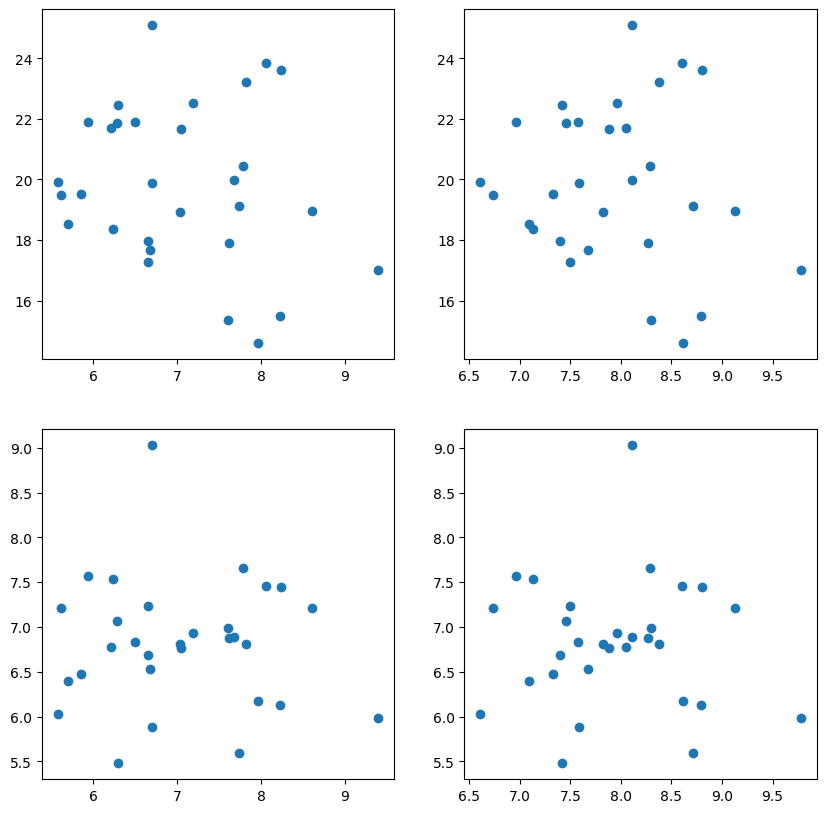

In [77]:
mape_p ,dh = mape_models


#
lossmin= np.array([[np.min(np.array(dh[i].history['loss'])),np.min(np.array(mape_pred[1][i].history['val_loss'])) ]for i in range(30)])
vallossmin= np.array([[np.min(np.array(dh[i].history['val_loss'])),np.min(np.array(mape_pred[1][i].history['val_loss'])) ]for i in range(30)])
lossmin2= np.array([[np.min(np.array(dh[i].history['loss'])),np.min(np.array(mape_pred[1][i].history['loss'])) ]for i in range(30)])
vallossmin2= np.array([[np.min(np.array(dh[i].history['val_loss'])),np.min(np.array(mape_pred[1][i].history['loss'])) ]for i in range(30)])

fig, axe =plt.subplots(2,2,figsize=(10,10))
axe[0,0].scatter(lossmin.T[0],lossmin.T[1]/10000);
axe[0,1].scatter(vallossmin.T[0],vallossmin.T[1]/10000);
axe[1,0].scatter(lossmin2.T[0],lossmin2.T[1]/10000);
axe[1,1].scatter(vallossmin2.T[0],vallossmin2.T[1]/10000);
#lossmin.T[0]
print('losscorr',np.corrcoef(lossmin.T[0],lossmin.T[1])[1][0])
print('vallosscorr',np.corrcoef(vallossmin.T[0],vallossmin.T[1])[1][0])
print('losscorr2',np.corrcoef(lossmin2.T[0],lossmin2.T[1])[1][0])
print('vallosscorr2',np.corrcoef(vallossmin2.T[0],vallossmin2.T[1])[1][0])

In [60]:
pred1= bagging_predict2(mape_p,test_X)
mse1 = np.array([mean_squared_error(test_y.flatten(),pred1[i].flatten()) for i in range(30)])

12/12 [==============================] - 0s 1ms/step


losscorr -0.32306909097341185
losscorr -0.34631465830757013


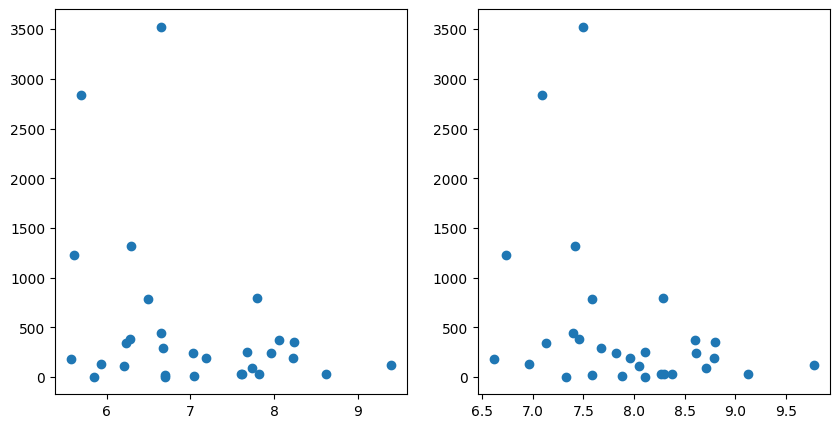

In [72]:
lossmse = np.array([[np.min(np.array(dh[i].history['loss'])),mse1[i]] for i in range(30)])
vallossmse = np.array([[np.min(np.array(dh[i].history['val_loss'])),mse1[i]] for i in range(30)])
fig, axe =plt.subplots(1,2,figsize=(10,5))
axe[0].scatter(lossmse.T[0],lossmse.T[1]);
axe[1].scatter(vallossmse.T[0],vallossmse.T[1]);

print('losscorr',np.corrcoef(lossmse.T[0],lossmse.T[1])[1][0])
print('vallosscorr',np.corrcoef(vallossmse.T[0],vallossmse.T[1])[1][0])

# smape
---

In [80]:
smape_models = train_bagging_models_G(30,SMAPE(),100,5,512,0.001)
smape_pred = transfer_(30,smape_models,True, SMAPE(),100,8,5,0.001)

'########################################################Model0
'########################################################Model1
'########################################################Model2
'########################################################Model3
'########################################################Model4
'########################################################Model5
'########################################################Model6
'########################################################Model7
'########################################################Model8
'########################################################Model9
'########################################################Model10
'########################################################Model11
'########################################################Model12
'########################################################Model13
'########################################################Model14
'##################################

In [88]:
lossmin.T[0][1:]

array([ 5.3639636 ,  7.14622164,  5.74890852,  5.02298641,  7.09873533,
       16.85827446,  6.20857191,  5.42390537, 15.51574993,  6.37786484,
        6.38124371,  5.43098879,  6.10883904,  4.79535389, 13.13965034,
        5.47264242,  8.32707405,  7.83360577,  6.74530602,  4.58590317,
        4.65035248,  7.14083767,  8.55998516,  7.14010429,  7.28727293,
        5.28447056,  6.31788635,  6.38278103,  5.83706093])

losscorr 0.15401390181155433
vallosscorr 0.17144830812207695
losscorr2 0.2503311458288951
vallosscorr2 0.2697492163806183


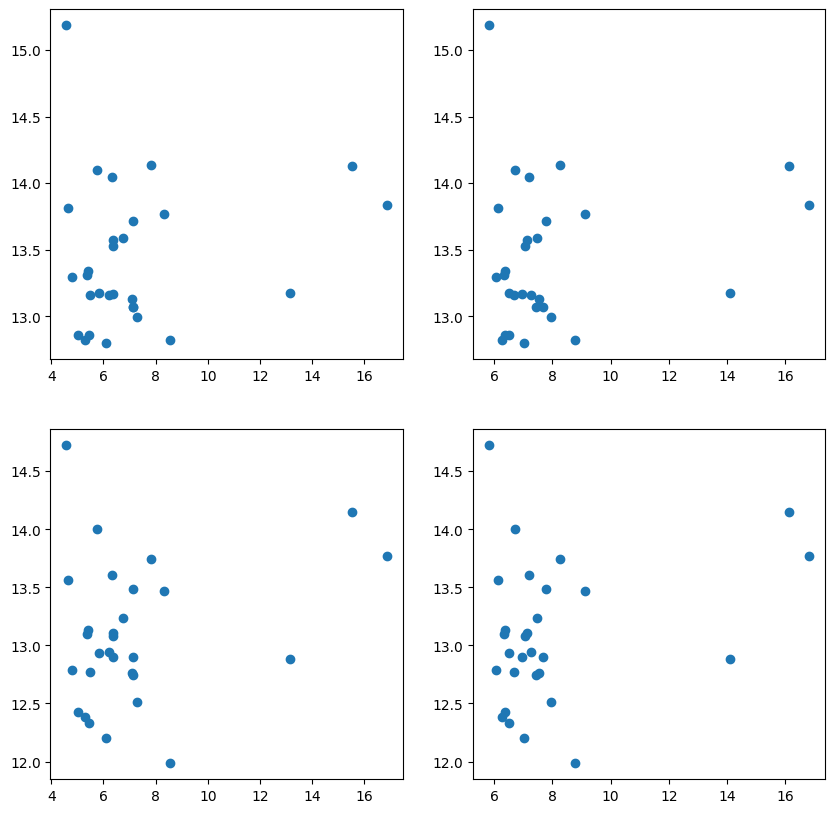

In [92]:
smape_p ,dh = smape_models


#
lossmin= np.array([[np.min(np.array(dh[i].history['loss'])),np.min(np.array(smape_pred[1][i].history['val_loss'])) ]for i in range(30)])
vallossmin= np.array([[np.min(np.array(dh[i].history['val_loss'])),np.min(np.array(smape_pred[1][i].history['val_loss'])) ]for i in range(30)])
lossmin2= np.array([[np.min(np.array(dh[i].history['loss'])),np.min(np.array(smape_pred[1][i].history['loss'])) ]for i in range(30)])
vallossmin2= np.array([[np.min(np.array(dh[i].history['val_loss'])),np.min(np.array(smape_pred[1][i].history['loss'])) ]for i in range(30)])

fig, axe =plt.subplots(2,2,figsize=(10,10))
axe[0,0].scatter(lossmin.T[0][1:],lossmin.T[1][1:]/10);
axe[0,1].scatter(vallossmin.T[0][1:],vallossmin.T[1][1:]/10);
axe[1,0].scatter(lossmin2.T[0][1:],lossmin2.T[1][1:]/10);
axe[1,1].scatter(vallossmin2.T[0][1:],vallossmin2.T[1][1:]/10);
#lossmin.T[0]
print('losscorr',np.corrcoef(lossmin.T[0][1:],lossmin.T[1][1:])[1][0])
print('vallosscorr',np.corrcoef(vallossmin.T[0][1:],vallossmin.T[1][1:])[1][0])
print('losscorr2',np.corrcoef(lossmin2.T[0][1:],lossmin2.T[1][1:])[1][0])
print('vallosscorr2',np.corrcoef(vallossmin2.T[0][1:],vallossmin2.T[1][1:])[1][0])

In [90]:
pred1= bagging_predict2(smape_p,test_X)
mse1 = np.array([mean_squared_error(test_y.flatten(),pred1[i].flatten()) for i in range(30)])

12/12 [==============================] - 0s 2ms/step


losscorr 0.10647570737816899
vallosscorr 0.07596091194041912


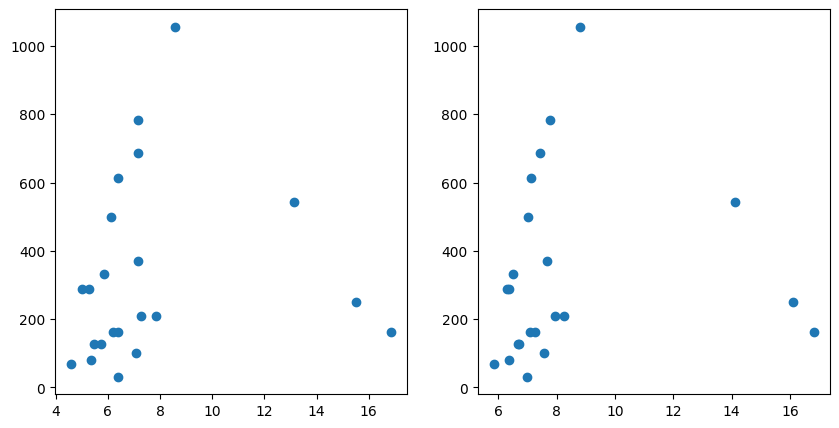

In [106]:
lossmse = np.array([[np.min(np.array(dh[i].history['loss'])),mse1[i]] for i in range(30)])
vallossmse = np.array([[np.min(np.array(dh[i].history['val_loss'])),mse1[i]] for i in range(30)])
fig, axe =plt.subplots(1,2,figsize=(10,5))
axe[0].scatter(lossmse.T[0][1:][lossmse.T[1][1:] <2000],lossmse.T[1][1:][lossmse.T[1][1:] <2000]);
axe[1].scatter(vallossmse.T[0][1:][vallossmse.T[1][1:]<2000],vallossmse.T[1][1:][vallossmse.T[1][1:]<2000]);

print('losscorr',np.corrcoef(lossmse.T[0][1:][vallossmse.T[1][1:]<2000],lossmse.T[1][1:][vallossmse.T[1][1:]<2000])[1][0])
print('vallosscorr',np.corrcoef(vallossmse.T[0][1:][vallossmse.T[1][1:]<2000],vallossmse.T[1][1:][vallossmse.T[1][1:]<2000])[1][0])

In [115]:
print(lossmin[mse1 == np.min(mse1)])
print(vallossmin[mse1 == np.min(mse1)])
print(lossmin2[mse1 == np.min(mse1)])
print(vallossmin2[mse1 == np.min(mse1)])


[[  6.38278103 131.67756653]]
[[  6.97669697 131.67756653]]
[[  6.38278103 129.00227356]]
[[  6.97669697 129.00227356]]


# mase
---

In [116]:

mase_models = train_bagging_models_G(30,MASE(y_train,y_train.shape[1]),100,5,512,0.001)
mase_pred = transfer_(30,mase_models,True, MASE(target_y,y_train.shape[1]),100,8,5,0.001)


'########################################################Model0
'########################################################Model1
'########################################################Model2
'########################################################Model3
'########################################################Model4
'########################################################Model5
'########################################################Model6
'########################################################Model7
'########################################################Model8
'########################################################Model9
'########################################################Model10
'########################################################Model11
'########################################################Model12
'########################################################Model13
'########################################################Model14
'##################################

losscorr -0.1110996507083361
vallosscorr -0.07200300508156274
losscorr2 -0.4462037298940699
vallosscorr2 -0.4191010171565053


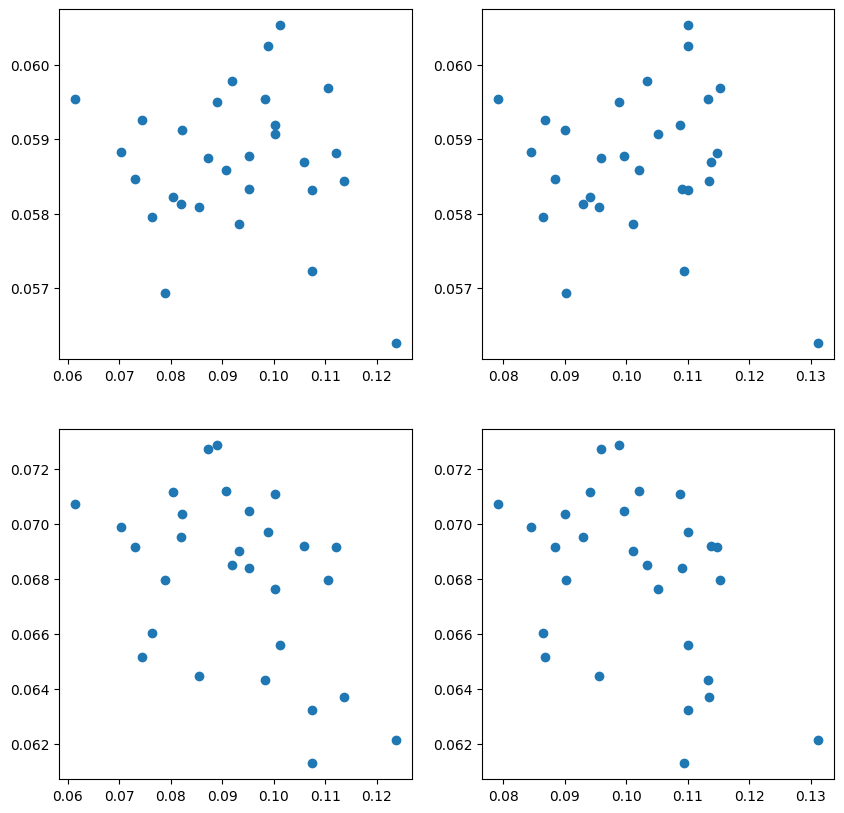

In [117]:
mase_p ,dh = mase_models


#
lossmin= np.array([[np.min(np.array(dh[i].history['loss'])),np.min(np.array(mase_pred[1][i].history['val_loss'])) ]for i in range(30)])
vallossmin= np.array([[np.min(np.array(dh[i].history['val_loss'])),np.min(np.array(mase_pred[1][i].history['val_loss'])) ]for i in range(30)])
lossmin2= np.array([[np.min(np.array(dh[i].history['loss'])),np.min(np.array(mase_pred[1][i].history['loss'])) ]for i in range(30)])
vallossmin2= np.array([[np.min(np.array(dh[i].history['val_loss'])),np.min(np.array(mase_pred[1][i].history['loss'])) ]for i in range(30)])

fig, axe =plt.subplots(2,2,figsize=(10,10))
axe[0,0].scatter(lossmin.T[0][1:],lossmin.T[1][1:]/10);
axe[0,1].scatter(vallossmin.T[0][1:],vallossmin.T[1][1:]/10);
axe[1,0].scatter(lossmin2.T[0][1:],lossmin2.T[1][1:]/10);
axe[1,1].scatter(vallossmin2.T[0][1:],vallossmin2.T[1][1:]/10);
#lossmin.T[0]
print('losscorr',np.corrcoef(lossmin.T[0][1:],lossmin.T[1][1:])[1][0])
print('vallosscorr',np.corrcoef(vallossmin.T[0][1:],vallossmin.T[1][1:])[1][0])
print('losscorr2',np.corrcoef(lossmin2.T[0][1:],lossmin2.T[1][1:])[1][0])
print('vallosscorr2',np.corrcoef(vallossmin2.T[0][1:],vallossmin2.T[1][1:])[1][0])

In [118]:
pred1= bagging_predict2(mase_p,test_X)
mse1 = np.array([mean_squared_error(test_y.flatten(),pred1[i].flatten()) for i in range(30)])

12/12 [==============================] - 0s 2ms/step


losscorr -0.5738863857058168
vallosscorr -0.5405192691957862


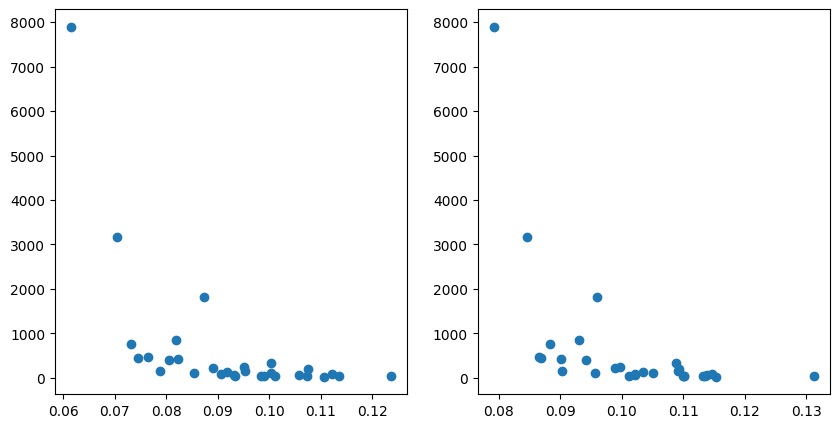

In [119]:
lossmse = np.array([[np.min(np.array(dh[i].history['loss'])),mse1[i]] for i in range(30)])
vallossmse = np.array([[np.min(np.array(dh[i].history['val_loss'])),mse1[i]] for i in range(30)])
fig, axe =plt.subplots(1,2,figsize=(10,5))
axe[0].scatter(lossmse.T[0],lossmse.T[1]);
axe[1].scatter(vallossmse.T[0],vallossmse.T[1]);

print('losscorr',np.corrcoef(lossmse.T[0],lossmse.T[1])[1][0])
print('vallosscorr',np.corrcoef(vallossmse.T[0],vallossmse.T[1])[1][0])

In [122]:
print(lossmin[mse1 == np.min(mse1)])
print(vallossmin[mse1 == np.min(mse1)])
print(lossmin2[mse1 == np.min(mse1)])
print(vallossmin2[mse1 == np.min(mse1)])
print(lossmin[mse1 == np.max(mse1)])
print(vallossmin[mse1 == np.max(mse1)])
print(lossmin2[mse1 == np.max(mse1)])
print(vallossmin2[mse1 == np.max(mse1)])

[[0.11060958 0.59692067]]
[[0.1152769  0.59692067]]
[[0.11060958 0.6794948 ]]
[[0.1152769 0.6794948]]
[[0.06151145 0.59544396]]
[[0.0791788  0.59544396]]
[[0.06151145 0.7074706 ]]
[[0.0791788 0.7074706]]


# mse
---

In [123]:

mse_models = train_bagging_models_G(30,'mse',100,5,512,0.001)
mse_pred = transfer_(30,mase_models,True,'mse' ,100,8,5,0.001)


'########################################################Model0
'########################################################Model1
'########################################################Model2
'########################################################Model3
'########################################################Model4
'########################################################Model5
'########################################################Model6
'########################################################Model7
'########################################################Model8
'########################################################Model9
'########################################################Model10
'########################################################Model11
'########################################################Model12
'########################################################Model13
'########################################################Model14
'##################################

losscorr -0.26213361723051476
vallosscorr -0.14561710582779452
losscorr2 0.058283412187940475
vallosscorr2 0.1481813730752612


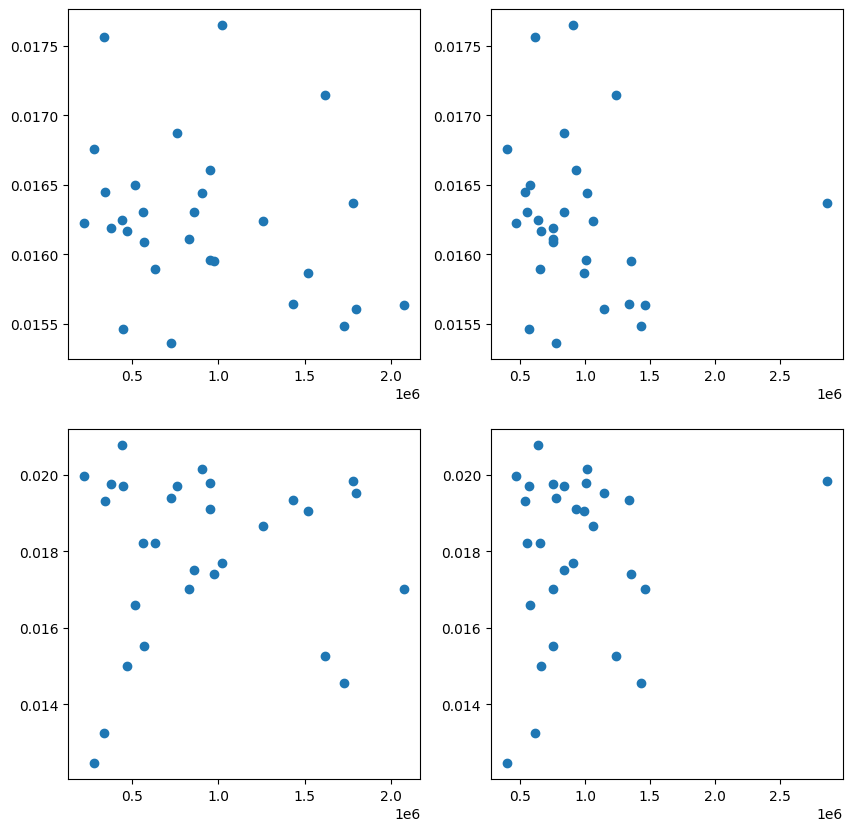

In [124]:
mse_p ,dh = mse_models


#
lossmin= np.array([[np.min(np.array(dh[i].history['loss'])),np.min(np.array(mse_pred[1][i].history['val_loss'])) ]for i in range(30)])
vallossmin= np.array([[np.min(np.array(dh[i].history['val_loss'])),np.min(np.array(mse_pred[1][i].history['val_loss'])) ]for i in range(30)])
lossmin2= np.array([[np.min(np.array(dh[i].history['loss'])),np.min(np.array(mse_pred[1][i].history['loss'])) ]for i in range(30)])
vallossmin2= np.array([[np.min(np.array(dh[i].history['val_loss'])),np.min(np.array(mse_pred[1][i].history['loss'])) ]for i in range(30)])

fig, axe =plt.subplots(2,2,figsize=(10,10))
axe[0,0].scatter(lossmin.T[0][1:],lossmin.T[1][1:]/10);
axe[0,1].scatter(vallossmin.T[0][1:],vallossmin.T[1][1:]/10);
axe[1,0].scatter(lossmin2.T[0][1:],lossmin2.T[1][1:]/10);
axe[1,1].scatter(vallossmin2.T[0][1:],vallossmin2.T[1][1:]/10);
#lossmin.T[0]
print('losscorr',np.corrcoef(lossmin.T[0][1:],lossmin.T[1][1:])[1][0])
print('vallosscorr',np.corrcoef(vallossmin.T[0][1:],vallossmin.T[1][1:])[1][0])
print('losscorr2',np.corrcoef(lossmin2.T[0][1:],lossmin2.T[1][1:])[1][0])
print('vallosscorr2',np.corrcoef(vallossmin2.T[0][1:],vallossmin2.T[1][1:])[1][0])

In [125]:
pred1= bagging_predict2(mse_p,test_X)
mse1 = np.array([mean_squared_error(test_y.flatten(),pred1[i].flatten()) for i in range(30)])

12/12 [==============================] - 0s 2ms/step


losscorr -0.6371279640654008
vallosscorr -0.49379337857940164


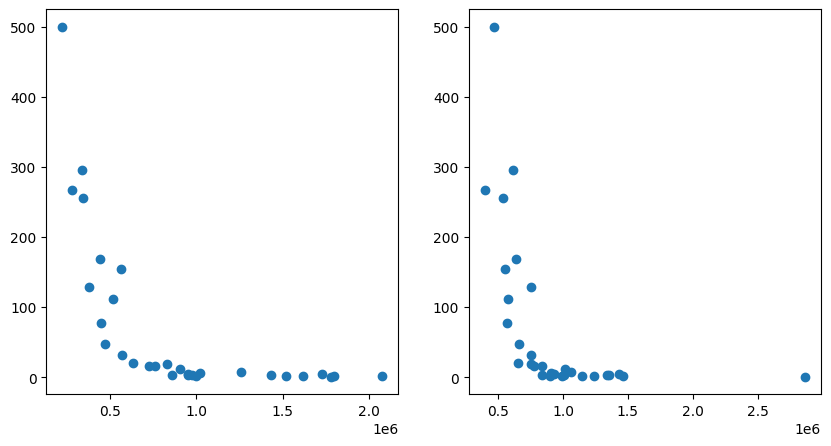

In [126]:
lossmse = np.array([[np.min(np.array(dh[i].history['loss'])),mse1[i]] for i in range(30)])
vallossmse = np.array([[np.min(np.array(dh[i].history['val_loss'])),mse1[i]] for i in range(30)])
fig, axe =plt.subplots(1,2,figsize=(10,5))
axe[0].scatter(lossmse.T[0],lossmse.T[1]);
axe[1].scatter(vallossmse.T[0],vallossmse.T[1]);

print('losscorr',np.corrcoef(lossmse.T[0],lossmse.T[1])[1][0])
print('vallosscorr',np.corrcoef(vallossmse.T[0],vallossmse.T[1])[1][0])

In [127]:
print(lossmin[mse1 == np.min(mse1)])
print(vallossmin[mse1 == np.min(mse1)])
print(lossmin2[mse1 == np.min(mse1)])
print(vallossmin2[mse1 == np.min(mse1)])
print(lossmin[mse1 == np.max(mse1)])
print(vallossmin[mse1 == np.max(mse1)])
print(lossmin2[mse1 == np.max(mse1)])
print(vallossmin2[mse1 == np.max(mse1)])

[[1.78057125e+06 1.63667783e-01]]
[[2.86481000e+06 1.63667783e-01]]
[[1.78057125e+06 1.98278621e-01]]
[[2.86481000e+06 1.98278621e-01]]
[[2.22656438e+05 1.62290096e-01]]
[[4.71632812e+05 1.62290096e-01]]
[[2.22656438e+05 1.99744970e-01]]
[[4.71632812e+05 1.99744970e-01]]


# mae
---

In [129]:

mae_models = train_bagging_models_G(30,'mae',100,5,512,0.001)
mae_pred = transfer_(30,mase_models,True,'mae' ,100,8,5,0.001)


'########################################################Model0
'########################################################Model1
'########################################################Model2
'########################################################Model3
'########################################################Model4
'########################################################Model5
'########################################################Model6
'########################################################Model7
'########################################################Model8
'########################################################Model9
'########################################################Model10
'########################################################Model11
'########################################################Model12
'########################################################Model13
'########################################################Model14
'##################################

losscorr 0.05414368141882171
vallosscorr -0.02062840118240949
losscorr2 -0.012587807262548842
vallosscorr2 -0.010760224854364071


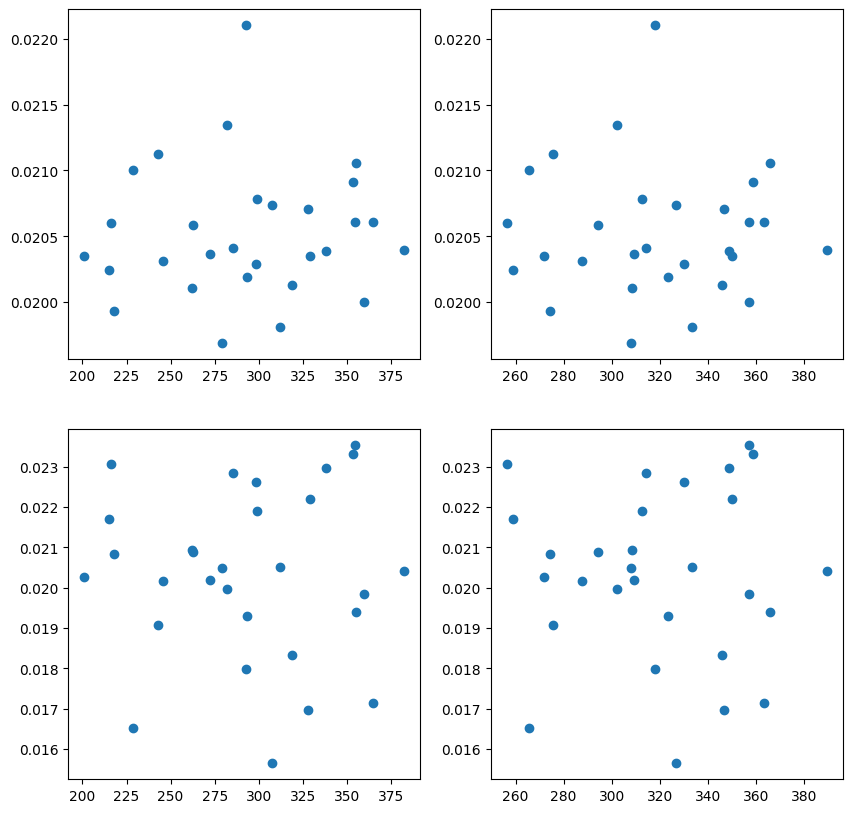

In [130]:
mae_p ,dh = mae_models


#
lossmin= np.array([[np.min(np.array(dh[i].history['loss'])),np.min(np.array(mae_pred[1][i].history['val_loss'])) ]for i in range(30)])
vallossmin= np.array([[np.min(np.array(dh[i].history['val_loss'])),np.min(np.array(mae_pred[1][i].history['val_loss'])) ]for i in range(30)])
lossmin2= np.array([[np.min(np.array(dh[i].history['loss'])),np.min(np.array(mae_pred[1][i].history['loss'])) ]for i in range(30)])
vallossmin2= np.array([[np.min(np.array(dh[i].history['val_loss'])),np.min(np.array(mae_pred[1][i].history['loss'])) ]for i in range(30)])

fig, axe =plt.subplots(2,2,figsize=(10,10))
axe[0,0].scatter(lossmin.T[0][1:],lossmin.T[1][1:]/10);
axe[0,1].scatter(vallossmin.T[0][1:],vallossmin.T[1][1:]/10);
axe[1,0].scatter(lossmin2.T[0][1:],lossmin2.T[1][1:]/10);
axe[1,1].scatter(vallossmin2.T[0][1:],vallossmin2.T[1][1:]/10);
#lossmin.T[0]
print('losscorr',np.corrcoef(lossmin.T[0][1:],lossmin.T[1][1:])[1][0])
print('vallosscorr',np.corrcoef(vallossmin.T[0][1:],vallossmin.T[1][1:])[1][0])
print('losscorr2',np.corrcoef(lossmin2.T[0][1:],lossmin2.T[1][1:])[1][0])
print('vallosscorr2',np.corrcoef(vallossmin2.T[0][1:],vallossmin2.T[1][1:])[1][0])

In [131]:
pred1= bagging_predict2(mae_p,test_X)
mse1 = np.array([mean_squared_error(test_y.flatten(),pred1[i].flatten()) for i in range(30)])

12/12 [==============================] - 0s 2ms/step


In [ ]:
lossmse = np.array([[np.min(np.array(dh[i].history['loss'])),mse1[i]] for i in range(30)])
vallossmse = np.array([[np.min(np.array(dh[i].history['val_loss'])),mse1[i]] for i in range(30)])
fig, axe =plt.subplots(1,2,figsize=(10,5))
axe[0].scatter(lossmse.T[0],lossmse.T[1]);
axe[1].scatter(vallossmse.T[0],vallossmse.T[1]);

print('losscorr',np.corrcoef(lossmse.T[0],lossmse.T[1])[1][0])
print('vallosscorr',np.corrcoef(vallossmse.T[0],vallossmse.T[1])[1][0])

In [4]:
concat_G = np.concatenate([np.array(mase_pred),np.array(mape_pred),np.array(smape_pred)])

fin_pred_G = np.median(concat_G,axis=0)

mean_squared_error(test_y.flatten(),fin_pred_G.flatten()),mean_absolute_error(test_y.flatten(),fin_pred_G.flatten())

(0.21760061579602696, 0.23856226847292922)